# Predictors of blood pressure in US adults

This case study uses data from the [National Health and Nutrition Examination Survey (NHANES)](https://www.cdc.gov/nchs/nhanes/index.htm) to identify predictors of systolic [blood pressure](https://en.wikipedia.org/wiki/Blood_pressure) in US adults.

NHANES is a [cross-sectional study](https://en.wikipedia.org/wiki/Cross-sectional_data) so in our data we have a single blood pressure measurement for each subject, along with many potential predictors (explanatory variables) that are acquired at the same point in time as the blood pressure is measured.  

It is important to keep in mind that NHANES is an [observational study](https://en.wikipedia.org/wiki/Observational_study), so relationships between variables identified using [regression analysis](https://en.wikipedia.org/wiki/Regression_analysis) may not be [causal](https://en.wikipedia.org/wiki/Causality) (e.g. they may reflect an unmeasured common cause).

Blood pressure is a somewhat volatile trait, so a single measurement may reflect transient factors that are not reflected in the covariates.  However some fraction of blood pressure variation is explained by covariates.  For example, we will see strong differences in blood pressure related to age, sex, body dimensions (height, weight, BMI), and race.  The roles of these explanatory variables will turn out to be nonlinear and non-additive.

All analyses below employ linear least squares ([OLS](https://en.wikipedia.org/wiki/Ordinary_least_squares)).  Models fit using OLS are ideal in [homoscedastic](https://en.wikipedia.org/wiki/Homoscedasticity_and_heteroscedasticity) settings (where the variance is constant in the mean).  This is not strictly true here, as demonstrated below, but holds to good approximation.  OLS can be employed in the presence of mild heteroscedasticity, but there may be a mild loss of precision (statistical power).


In [ ]:
import pandas as pd
import os
import numpy as np
import patsy
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

The data are available from the NHANES web site.  We can read the data directly from the internet, you do not need to download the data files.  The data for different traits are stored in different files.  There are many files for each NHANES wave, but here we will use only three of them, the demographics file (DEMO), the body measurements file (BMX), and the blood pressure file (BPX).

These files can be merged on the subject identifier SEQN to produce a single data file that we will use below.



In [ ]:
pa = "https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018"

fn = ["DEMO_J.XPT", "BMX_J.XPT", "BPX_J.XPT"]

da = []
for f in fn:
    dx = pd.read_sas(os.path.join(pa, f))
    da.append(dx)

df = pd.merge(da[0], da[1], how="left", on="SEQN")
df = pd.merge(df, da[2], how="left", on="SEQN")

df["RIAGENDR"] = df["RIAGENDR"].replace([1, 2], ["M", "F"])
df["RIDRETH1"] = df["RIDRETH1"].replace([1, 2, 3, 4, 5], ["MA", "OH", "NHW", "NHB", "Other"])

df = df.loc[df.RIDAGEYR >= 18, :]

The following cell customizes the colors for the plots to be made below.

In [ ]:
cm = matplotlib.colormaps["tab10"]

The focus of this notebook is on the explanatory variables for systolilc blood pressure (SBP).  Mainly we will focus on age, sex, BMI (body mass index), and to some extent race.  A very simplistic way to get started is to view a scatterplot of SBP against age.  This gives us a bit of insight into the marginal relationship between SBP and age, but tells us nothing about the other factors.  We add to this plot an nonparametric estimate of the regression function, based on a "scatterplot smoothing" algorithm called [loess](https://en.wikipedia.org/wiki/Local_regression).

Text(0, 0.5, 'SBP')

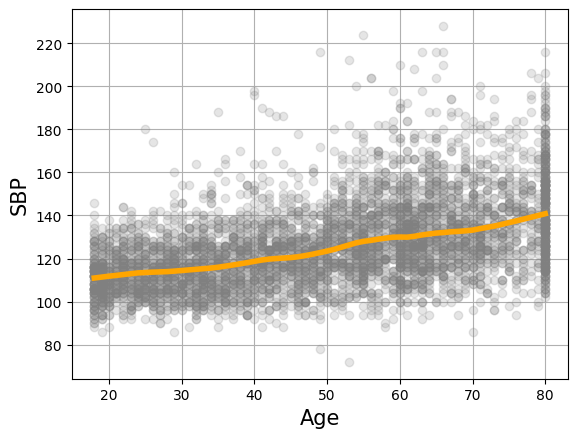

In [ ]:
xl = lowess(df["BPXSY1"], df["RIDAGEYR"], frac=0.2)

plt.grid(True)
plt.plot(df["RIDAGEYR"], df["BPXSY1"], "o", color="grey", alpha=0.2)
plt.plot(xl[:, 0], xl[:, 1], '-', color="orange", lw=4)
plt.xlabel("Age", size=15)
plt.ylabel("SBP", size=15)

Below we define four functions that plot fitted mean blood pressure as a function of age, for specific settings of other variables of interest.  These plots are the main way that we interpret the models to be fit below, since many of the models are too complex to interpret directly.

In [ ]:
dp = df.iloc[0:50, :].copy()
dp["RIDAGEYR"] = np.linspace(18, 80, 50)
dp["RIDRETH1"] = "MA"

db = df.iloc[0:50, :].copy()
db["BMXBMI"] = np.linspace(20, 50, 50)
db["RIDRETH1"] = "MA"
db["RIDAGEYR"] = 50

In [ ]:
def plot1(rr, ii, dbands=False, bmi=25):
    """"
    Plot predicted SBP by sex at fixed BMI.  Optionally, broken lines at +/- 1 SD are also plotted.
    """
    sigma = np.sqrt(rr.scale)
    plt.figure(figsize=(5, 3))
    plt.clf()
    plt.axes([0.12, 0.12, 0.65, 0.8])
    plt.grid(True)
    for (jj,sex) in enumerate(["F", "M"]):
        dp["RIAGENDR"] = sex
        dp["BMXBMI"] = bmi
        yh = rr.predict(exog=dp)
        plt.plot(dp.RIDAGEYR, yh, color=cm(jj/10), label={"F": "Female", "M": "Male"}[sex])
        if dbands:
            plt.plot(dp.RIDAGEYR, yh + sigma, ":", color=cm(jj/10))
            plt.plot(dp.RIDAGEYR, yh - sigma, ":", color=cm(jj/10))
    plt.xlabel("Age", size=14)
    plt.ylabel("SBP", size=14)
    plt.title("Model %d" % ii)
    ha, lb = plt.gca().get_legend_handles_labels()
    leg = plt.figlegend(ha, lb, loc="center right")
    leg.draw_frame(False)
    plt.show()

In [ ]:
def plot2(rr, ii, bmis = [25, 30]):
    """
    Plot predicted SBP by sex at two different BMI levels (25 versus 30).
    """
    plt.figure(figsize=(5.5, 3))
    plt.clf()
    plt.axes([0.12, 0.12, 0.65, 0.8])
    plt.grid(True)
    for sex in ["F", "M"]:
        for bmi in bmis:
            dp["RIAGENDR"] = sex
            dp["BMXBMI"] = bmi
            yh = rr.predict(exog=dp)
            plt.plot(dp.RIDAGEYR, yh, label="%s/%.0f" %
                     ({"F": "Female", "M": "Male"}[sex], bmi))
    plt.xlabel("Age", size=14)
    plt.ylabel("SBP", size=14)
    plt.title("Model %d" % ii)
    ha, lb = plt.gca().get_legend_handles_labels()
    leg = plt.figlegend(ha, lb, loc="center right")
    leg.draw_frame(False)
    leg.set_title("Sex/BMI")
    plt.show()

In [ ]:
def plot3(rr, ii, bmi=25):
    """
    Compare females and males at fixed BMI, for each age, with confidence bands.
    """
    dp["BMXBMI"] = bmi
    yy, xm = [], []
    for sex in ["F", "M"]:
        dp["RIAGENDR"] = sex
        xx = patsy.dmatrix(rr.model.data.design_info, dp, return_type="dataframe")
        xm.append(xx)
        y = rr.predict(exog=dp)
        yy.append(y)
    xd = xm[0] - xm[1]
    vc = np.dot(xd, np.dot(rr.cov_params(), xd.T))
    se = np.sqrt(np.diag(vc))
    yd = yy[0] - yy[1]

    plt.figure(figsize=(5, 3))
    plt.clf()
    plt.axes([0.12, 0.12, 0.65, 0.8])
    plt.grid(True)
    plt.fill_between(dp.RIDAGEYR, yd-2*se, yd+2*se, color="grey")
    plt.plot(dp.RIDAGEYR, yd, color="black")
    plt.xlabel("Age", size=14)
    plt.ylabel("SBP difference", size=14)
    plt.title("Model %d" % ii)
    plt.title("SBP difference based on sex (F-M) at BMI=25")
    plt.show()

In [ ]:
def plot4(rr, ii, sex="F"):
    """
    Compare BMI 25 to BMI 30, for one sex only.
    """
    dp["RIAGENDR"] = sex
    yy, xm = [], []
    for bmi in [30, 25]:
        dp["BMXBMI"] = bmi
        xx = patsy.dmatrix(rr.model.data.design_info, dp, return_type="dataframe")
        xm.append(xx)
        y = rr.predict(exog=dp)
        yy.append(y)
    xd = xm[0] - xm[1]
    vc = np.dot(xd, np.dot(rr.cov_params(), xd.T))
    se = np.sqrt(np.diag(vc))
    yd = yy[0] - yy[1]

    plt.figure(figsize=(5, 3))
    plt.clf()
    plt.axes([0.12, 0.12, 0.65, 0.8])
    plt.grid(True)
    plt.fill_between(dp.RIDAGEYR, yd-2*se, yd+2*se, color="grey")
    plt.plot(dp.RIDAGEYR, yd, color="black")
    plt.xlabel("Age", size=14)
    plt.ylabel("SBP", size=14)
    plt.title("Model %d" % ii)
    plt.title("SBP difference based on BMI (30-25) for females")
    plt.show()

In [ ]:
def plot5(rr, ii, ages = [40, 60]):
    """
    Plot predicted SBP by BMI at two different age levels (40 and 60).
    """
    plt.figure(figsize=(5.5, 3))
    plt.clf()
    plt.axes([0.12, 0.12, 0.65, 0.8])
    plt.grid(True)
    for sex in ["F", "M"]:
        db["RIAGENDR"] = sex
        for age in ages:
            db["RIDAGEYR"] = age
            yh = rr.predict(exog=db)
            plt.plot(db.BMXBMI, yh, label="%s/%.0f" %
                     ({"F": "Female", "M": "Male"}[sex], age))
    plt.xlabel("BMI", size=14)
    plt.ylabel("SBP", size=14)
    plt.title("Model %d" % ii)
    ha, lb = plt.gca().get_legend_handles_labels()
    leg = plt.figlegend(ha, lb, loc="center right")
    leg.draw_frame(False)
    leg.set_title("Sex/Age")
    plt.show()

In [ ]:
def plot_all(rr, ii):
    plot1(rr, ii, bmi=25)
    plot1(rr, ii, dbands=True)
    plot2(rr, ii, bmis=[25, 30])
    plot3(rr, ii, bmi=25)
    plot4(rr, ii, sex="F")
    plot5(rr, ii, ages=[40, 60])

The first model is a very basic additive model expressing expected blood pressure as a linear function of age, sex, and BMI.  This is a "linear mean structure model" in the sense that blood pressure is modeled as a linear function of age for fixed values of sex and BMI.  It is also modeled as a linear function of BMI for fixed values of sex and age.

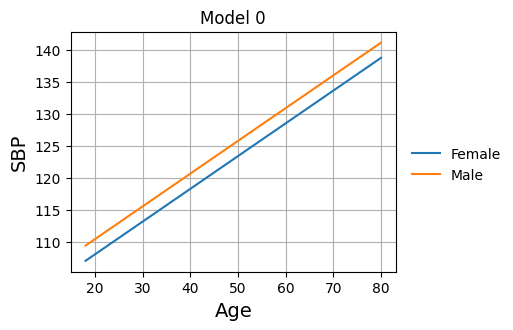

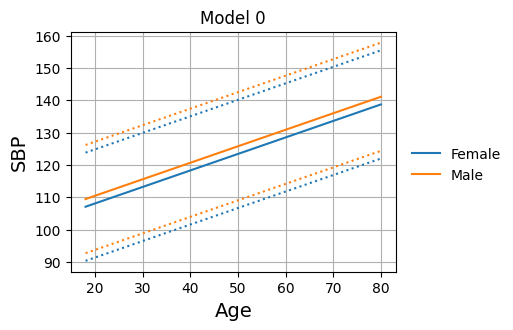

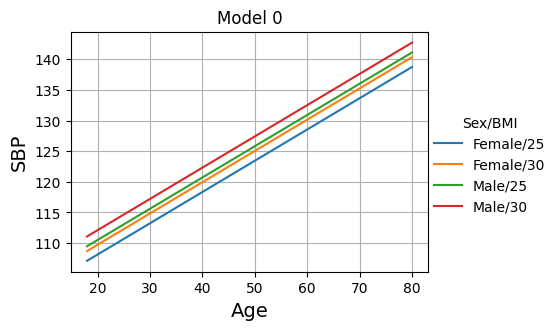

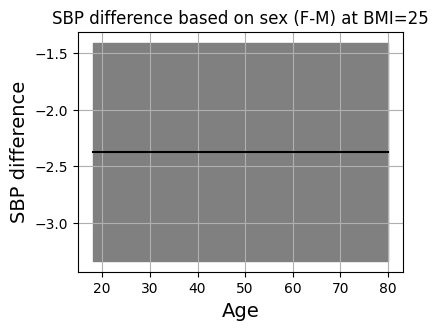

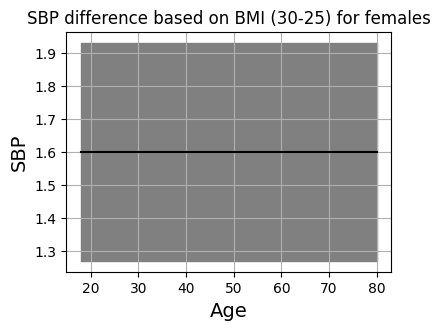

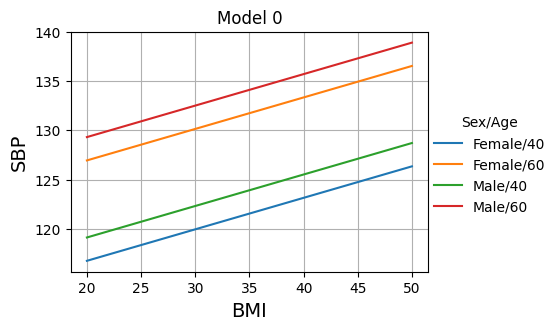

In [ ]:
f0 = "BPXSY1 ~ RIDAGEYR + RIAGENDR + BMXBMI"
m0 = sm.OLS.from_formula(f0, df)
r0 = m0.fit()
plot_all(r0, 0)

Model 1 allows the age slopes to differ by sex, while additively controlling for BMI.

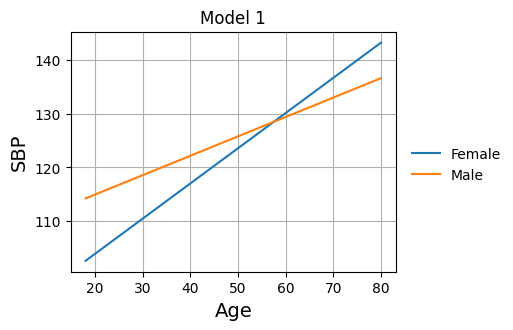

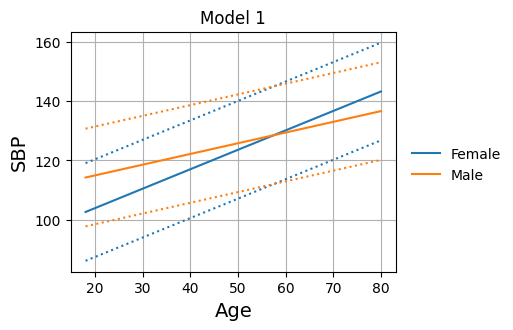

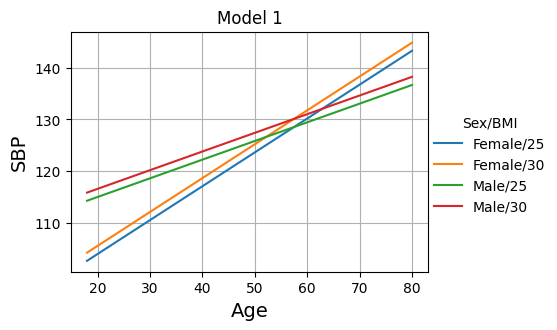

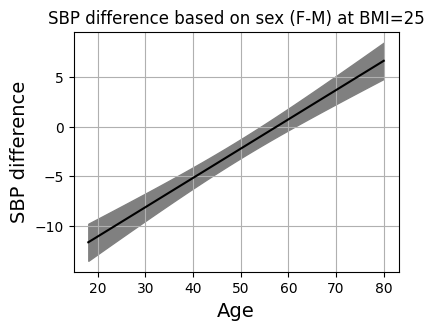

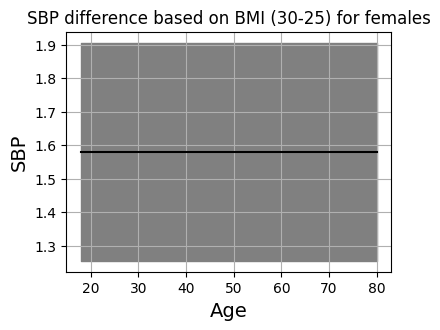

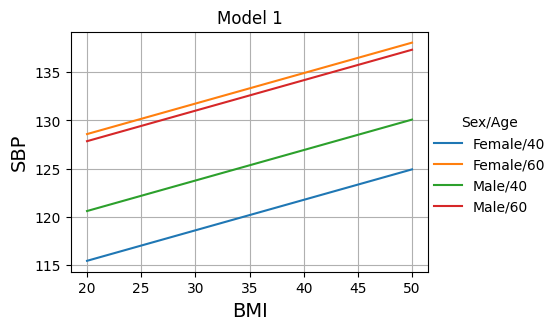

In [ ]:
f1 = "BPXSY1 ~ RIDAGEYR * RIAGENDR + BMXBMI"
m1 = sm.OLS.from_formula(f1, df)
r1 = m1.fit()
plot_all(r1, 1)

In model 2, we allow the BMI slopes to differ by sex, while additively controlling for age.

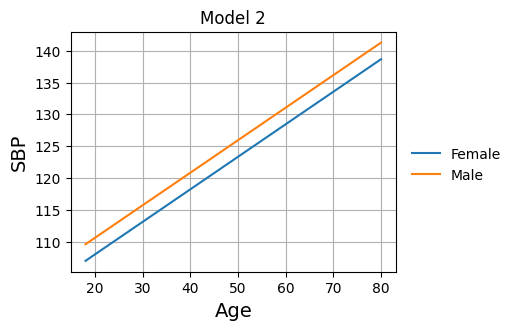

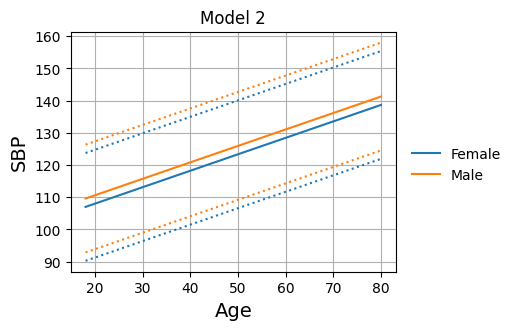

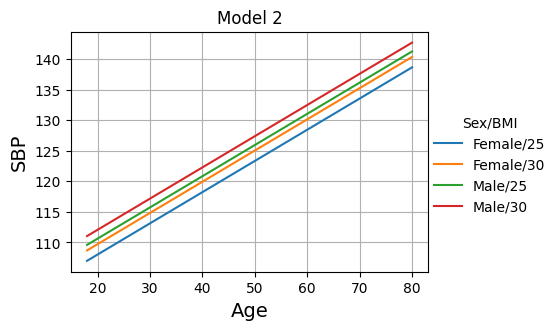

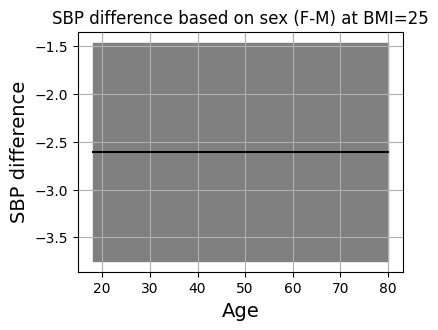

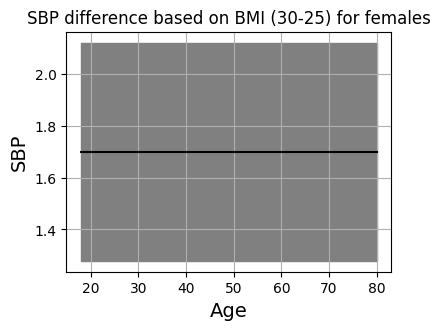

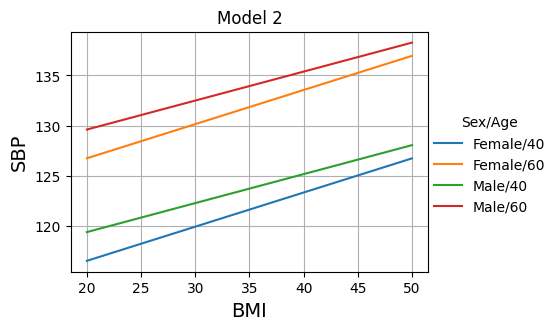

In [ ]:
f2 = "BPXSY1 ~ RIDAGEYR + RIAGENDR * BMXBMI"
m2 = sm.OLS.from_formula(f2, df)
r2 = m2.fit()
plot_all(r2, 2)

Model 3 allows both the age and BMI slopes to differ by sex.

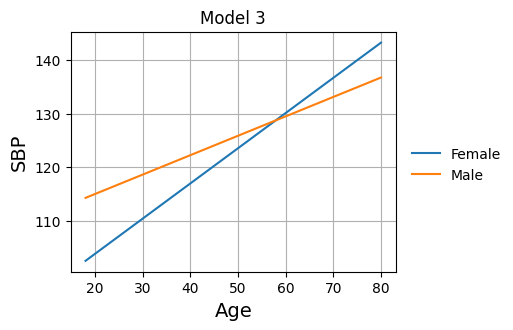

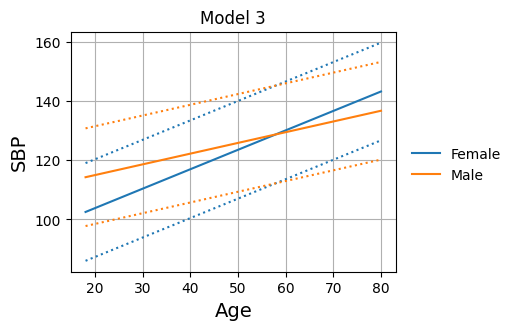

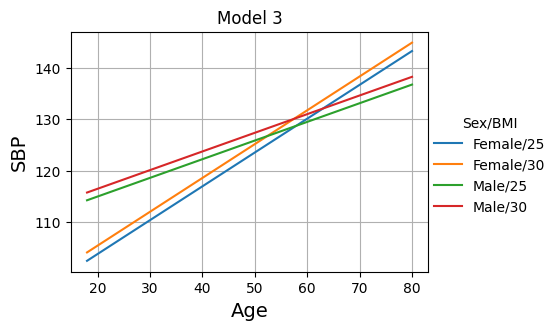

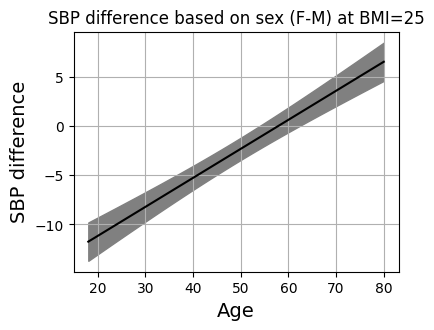

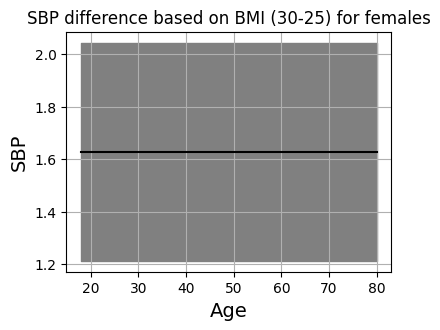

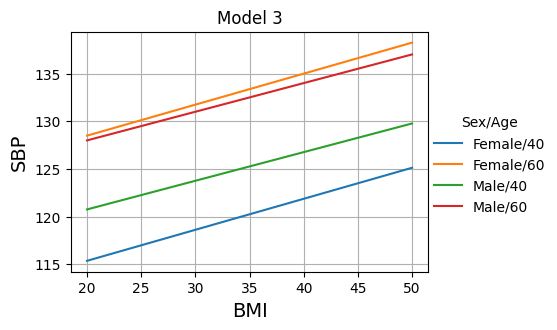

In [ ]:
f3 = "BPXSY1 ~ (RIDAGEYR + BMXBMI) * RIAGENDR"
m3 = sm.OLS.from_formula(f3, df)
r3 = m3.fit()
plot_all(r3, 3)

Model 4 has full interactions among age, BMI, and sex.

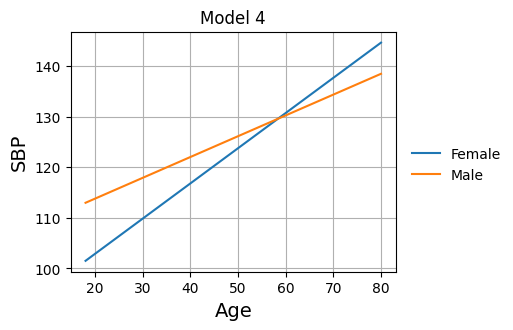

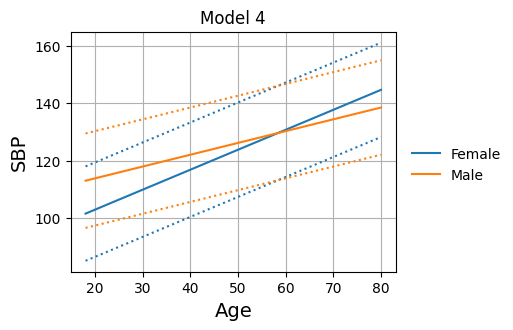

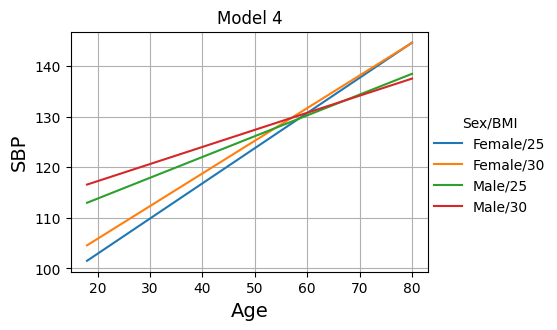

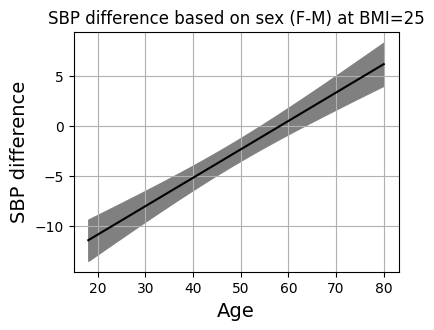

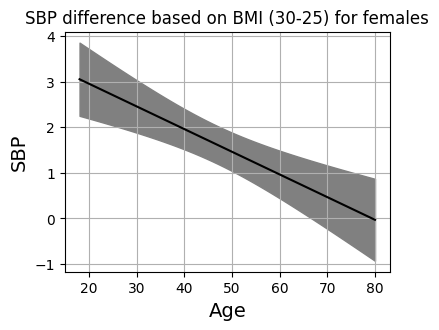

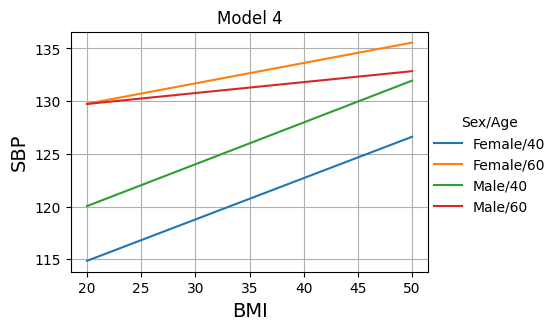

In [ ]:
f4 = "BPXSY1 ~ RIDAGEYR * BMXBMI * RIAGENDR"
m4 = sm.OLS.from_formula(f4, df)
r4 = m4.fit()
plot_all(r4, 4)

We can use the AIC to assess the goodness of fit of the models consider so far.  A lower AIC reflects a better fitting model.

In [ ]:
print("AIC for models 0-4:")
aic = np.asarray([x.aic for x in (r0, r1, r2, r3, r4)])
aic -= aic.min()
print(aic)

AIC for models 0-4:
[167.07979597  37.49071634 168.50666375  39.35451168   0.        ]


All models above treated quantitative variables (age and BMI) linearly.  Now we turn to the use of basis functions to capture nonlinear roles for these quantitative variables.  Model 5 allows for a nonlinear relationship between age and expected blood pressure, with additive control for sex and BMI.

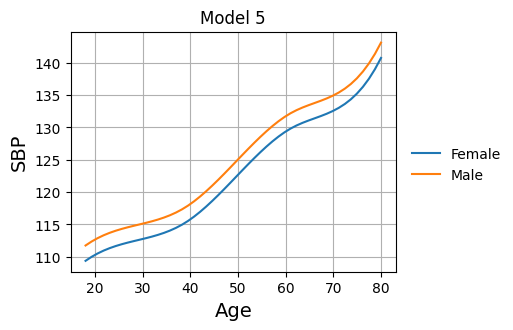

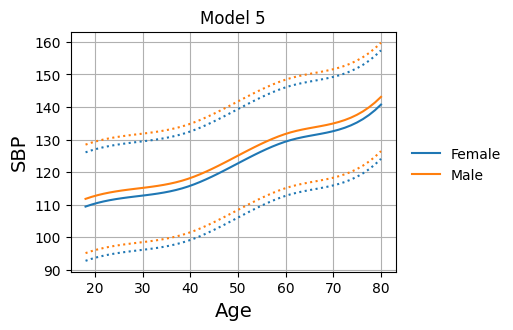

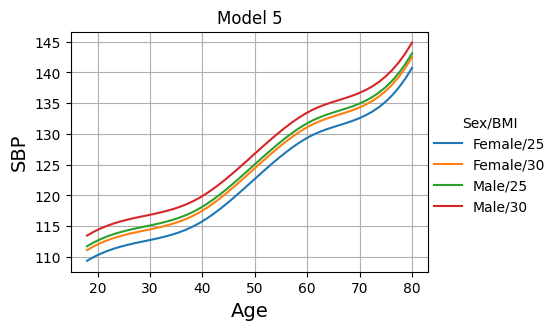

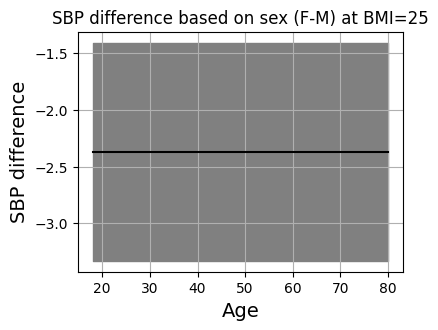

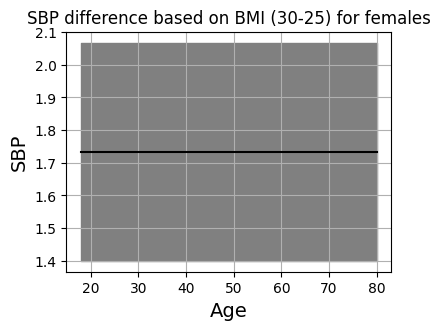

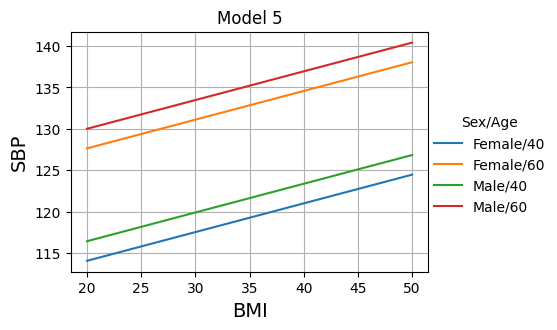

In [ ]:
f5 = "BPXSY1 ~ bs(RIDAGEYR, 5) + RIAGENDR + BMXBMI"
m5 = sm.OLS.from_formula(f5, df)
r5 = m5.fit()
plot_all(r5, 5)

Model 6 allows the age trends to differ by sex.

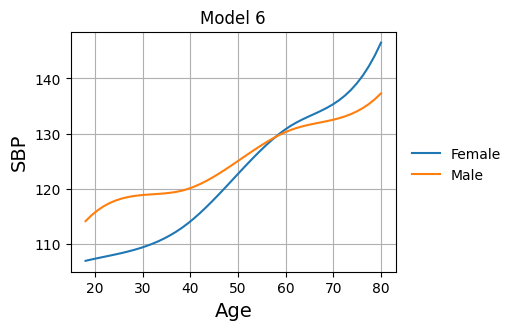

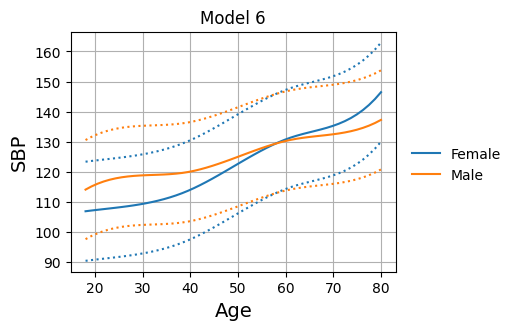

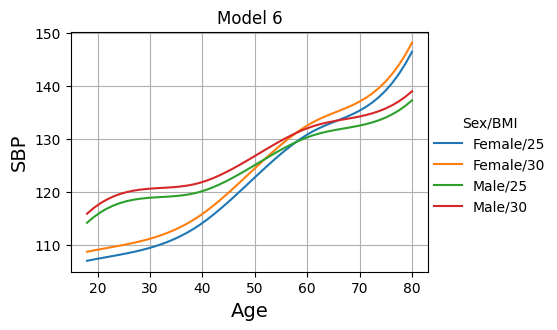

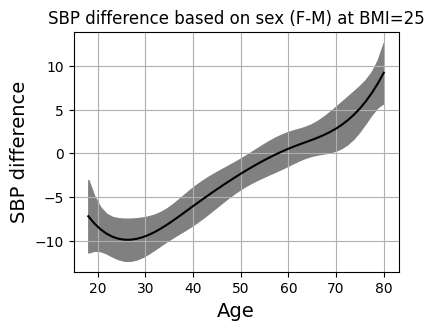

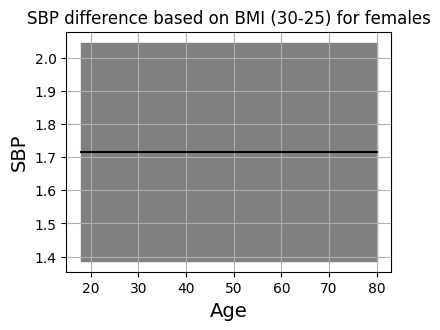

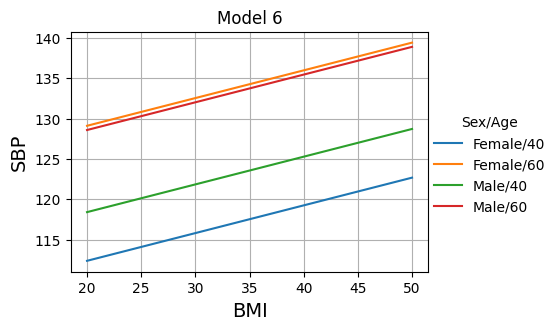

In [ ]:
f6 = "BPXSY1 ~ bs(RIDAGEYR, 5) * RIAGENDR + BMXBMI"
m6 = sm.OLS.from_formula(f6, df)
r6 = m6.fit()
plot_all(r6, 6)

Model 7 allows BMI trends to differ by sex, but BMI trends remain linear while age is modeled nonlinearly.

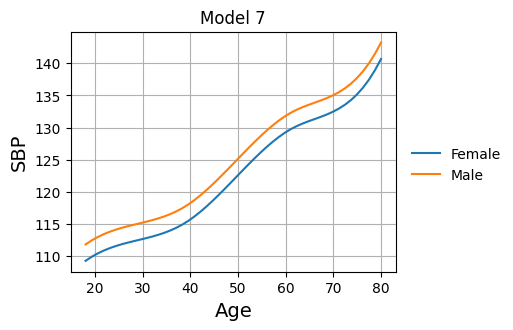

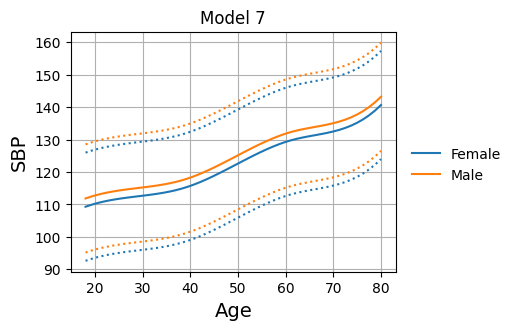

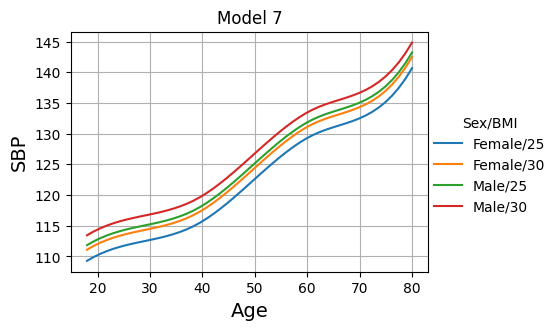

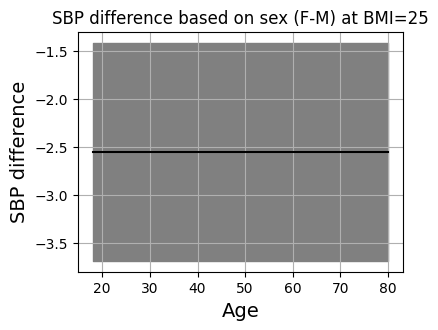

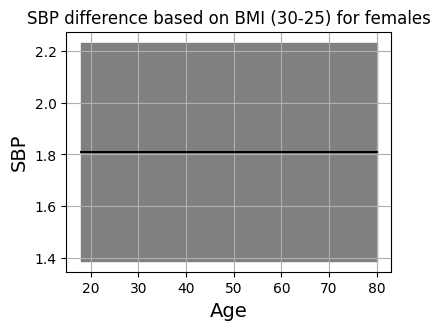

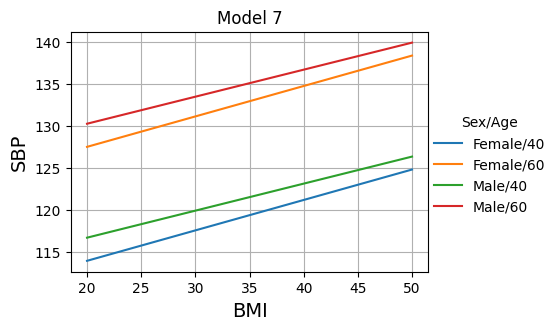

In [ ]:
# Allow BMI trends to differ by sex
f7 = "BPXSY1 ~ bs(RIDAGEYR, 5) + RIAGENDR * BMXBMI"
m7 = sm.OLS.from_formula(f7, df)
r7 = m7.fit()
plot_all(r7, 7)

Model 8 allows both the nonlinear age and linear BMI effects to differ by sex.

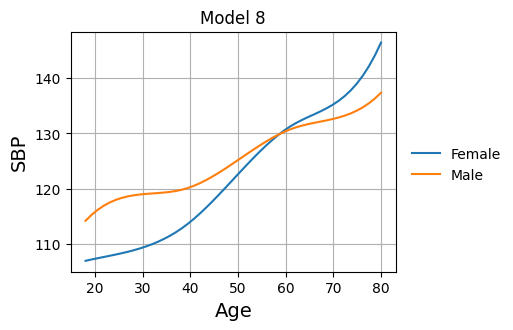

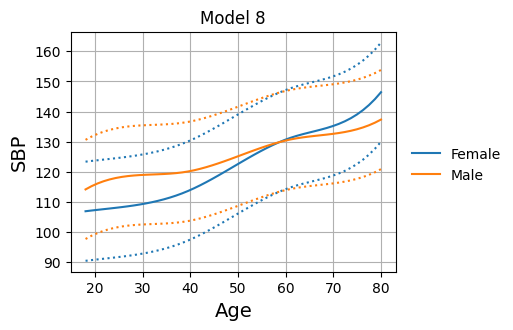

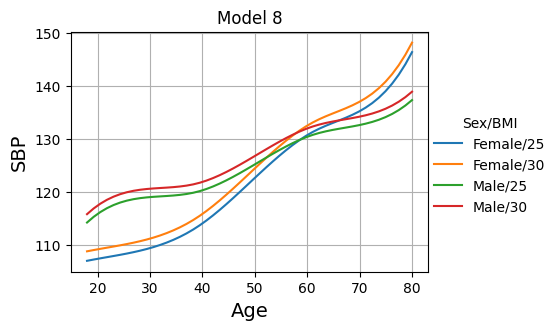

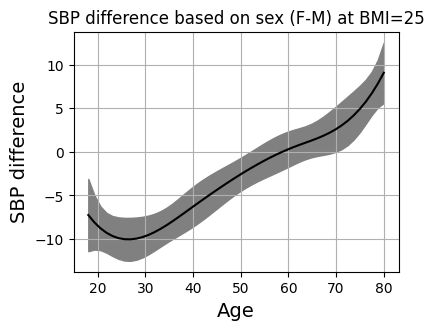

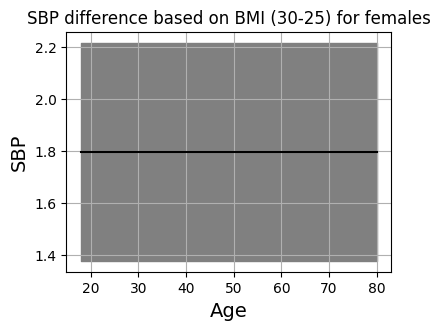

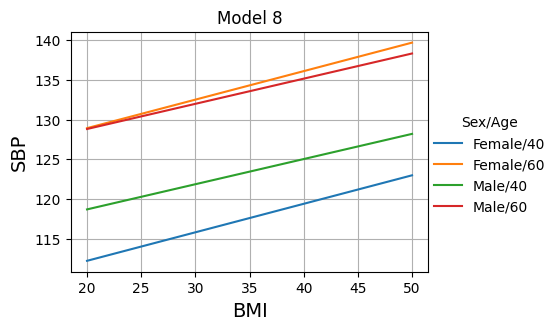

In [ ]:
f8 = "BPXSY1 ~ (bs(RIDAGEYR, 5) + BMXBMI) * RIAGENDR"
m8 = sm.OLS.from_formula(f8, df)
r8 = m8.fit()
plot_all(r8, 8)

Model 9 allows full interactions among nonlinear age, linear BMI, and sex.

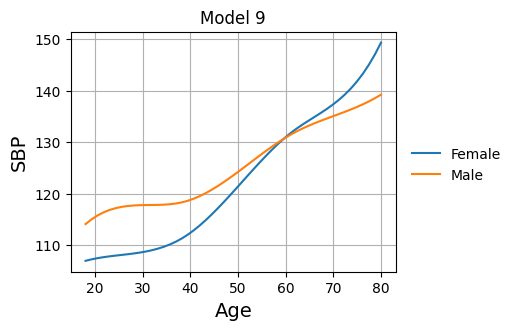

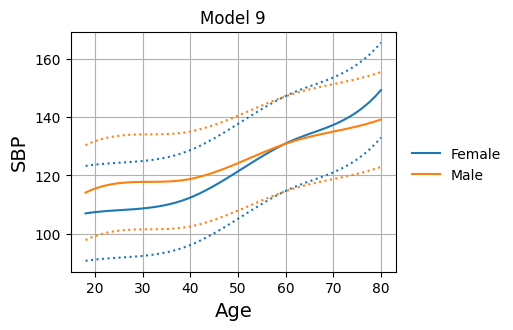

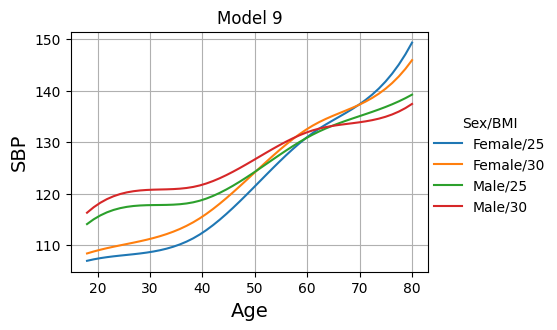

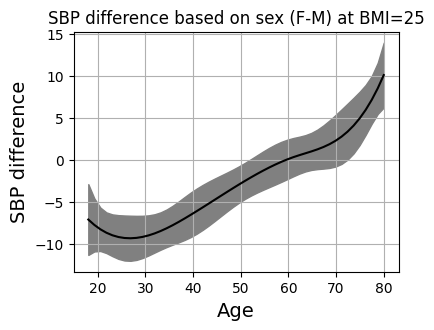

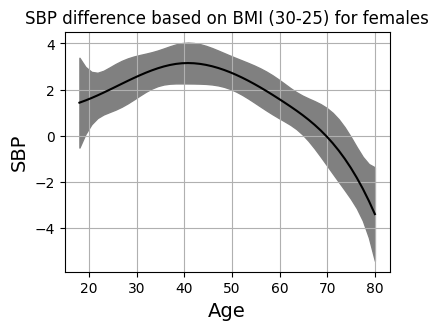

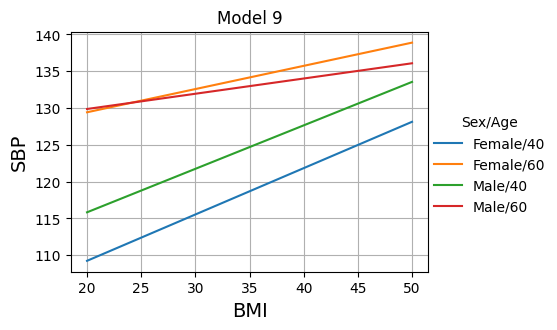

In [ ]:
f9 = "BPXSY1 ~ bs(RIDAGEYR, 5) * BMXBMI * RIAGENDR"
m9 = sm.OLS.from_formula(f9, df)
r9 = m9.fit()
plot_all(r9, 9)

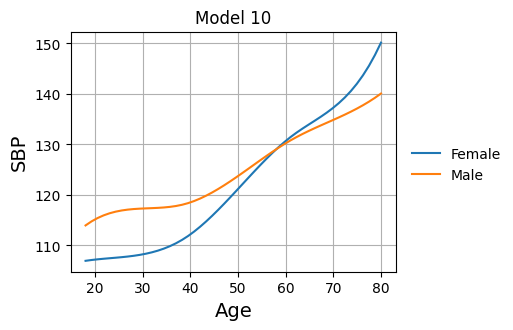

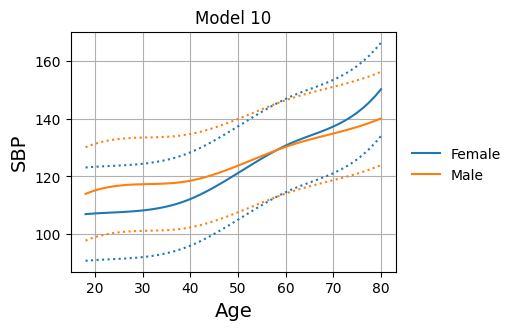

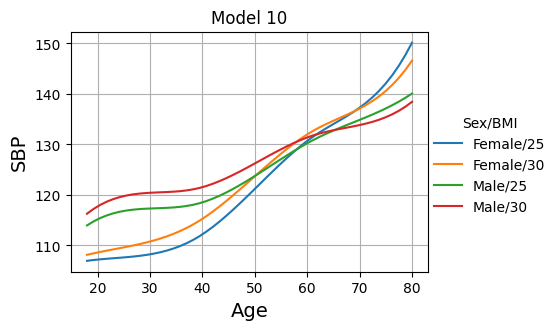

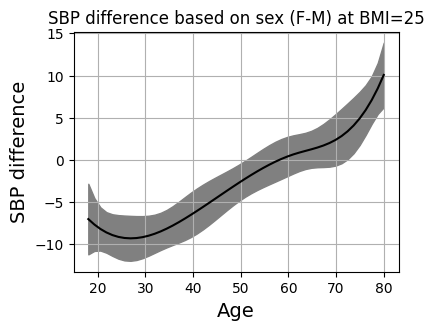

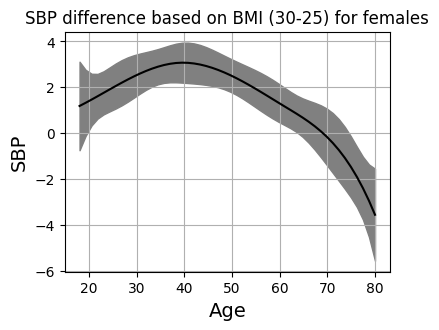

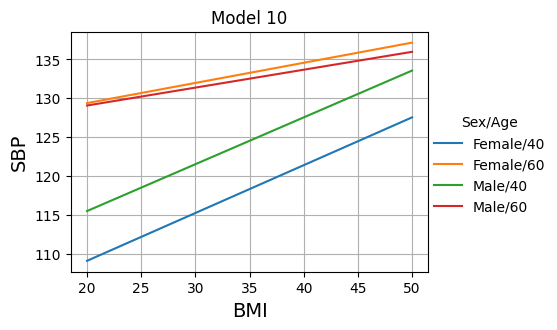

In [ ]:
# Full interactions among nonlinear age, BMI, and sex with additive control for ethnicity
f10 = "BPXSY1 ~ bs(RIDAGEYR, 5) * BMXBMI * RIAGENDR + RIDRETH1"
m10 = sm.OLS.from_formula(f10, df)
r10 = m10.fit()
plot_all(r10, 10)

Model 11 has everything from model 10 and also includes main effects for ethnicity and an ethnicity x sex interaction.

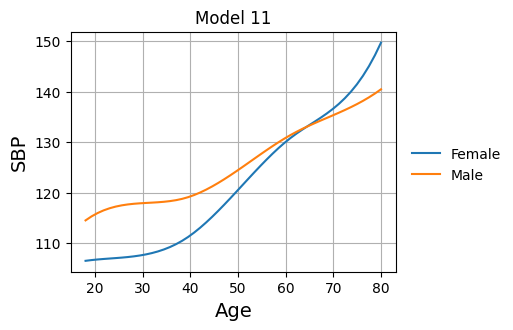

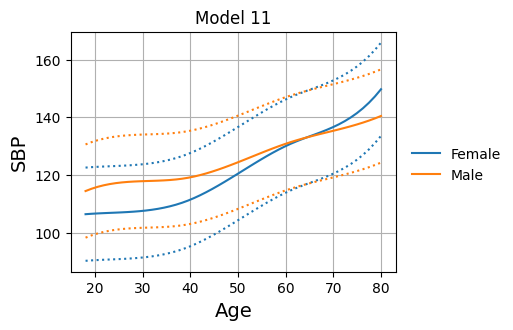

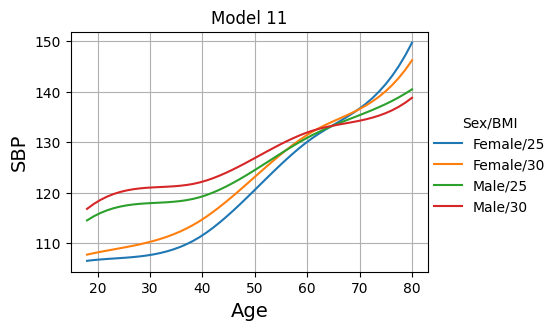

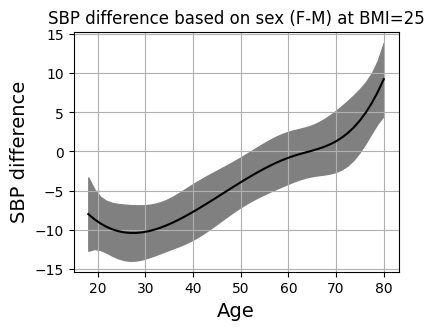

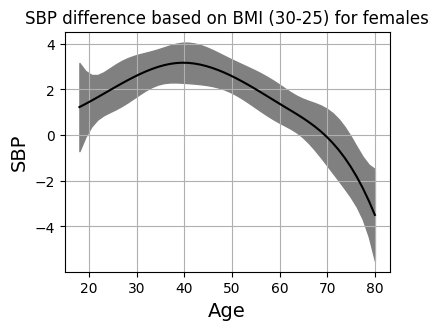

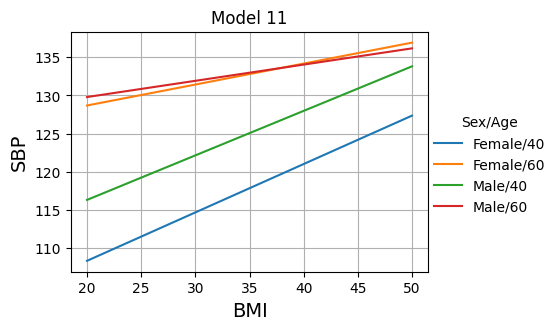

In [ ]:
f11 = "BPXSY1 ~ (bs(RIDAGEYR, 5) * BMXBMI + RIDRETH1) * RIAGENDR"
m11 = sm.OLS.from_formula(f11, df)
r11 = m11.fit()
plot_all(r11, 11)

Model 12 has full interactions among nonlinear age, BMI, and sex, and between sex and ethnicity, and between linear age and ethnicity.

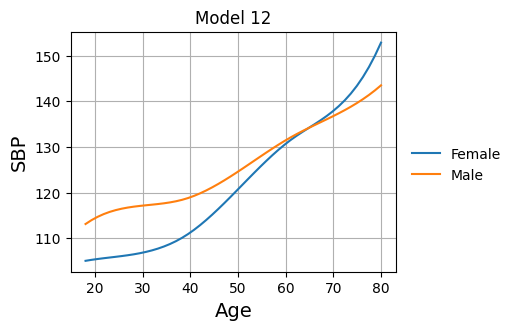

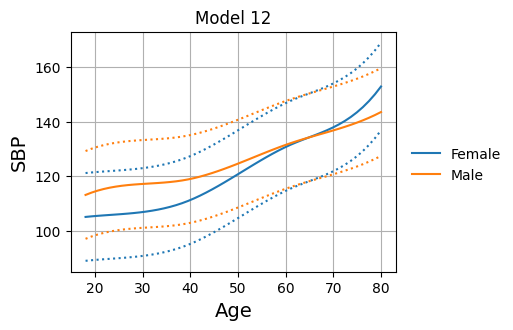

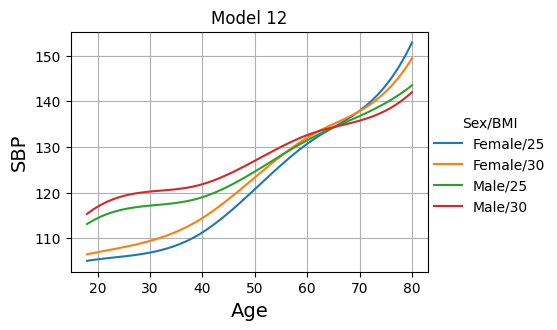

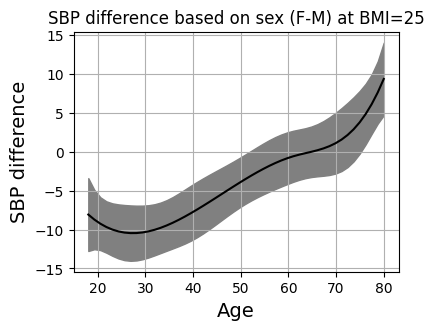

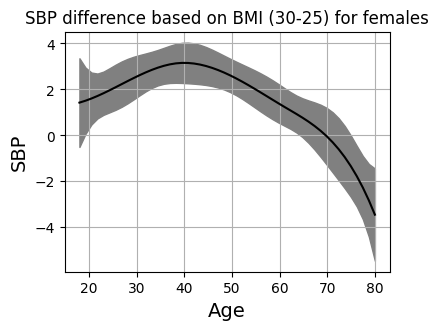

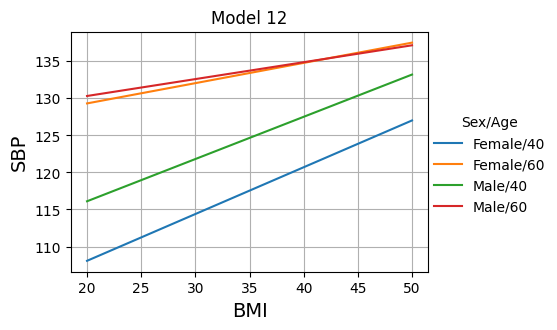

In [ ]:
f12 = "BPXSY1 ~ bs(RIDAGEYR, 5) * BMXBMI * RIAGENDR + (RIAGENDR + RIDAGEYR) * RIDRETH1"
m12 = sm.OLS.from_formula(f12, df)
r12 = m12.fit()
plot_all(r12, 12)

Model 13 has full interactions among nonlinear age, BMI, and sex, and between sex and ethnicity, and between nonlinear age and ethnicity.

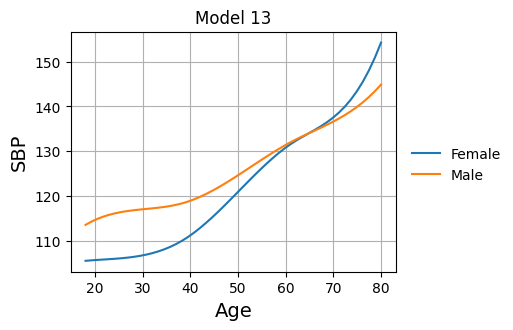

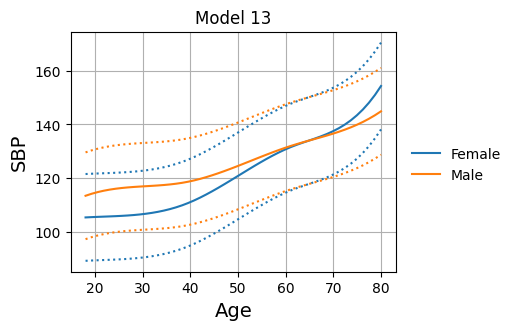

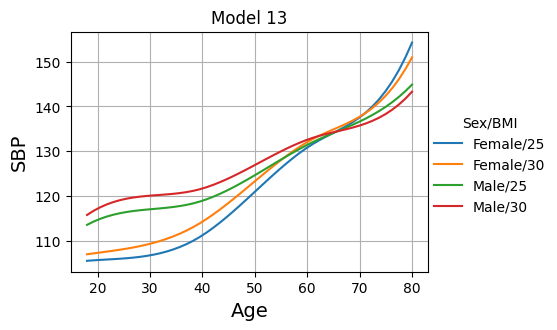

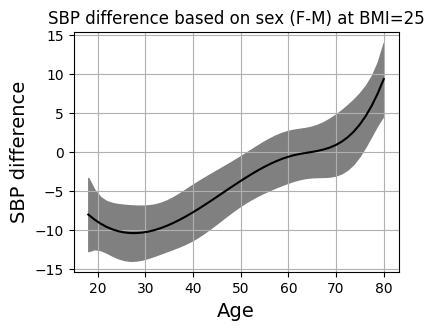

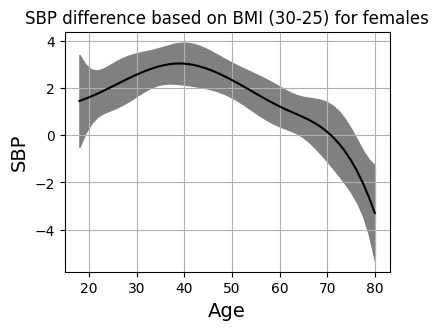

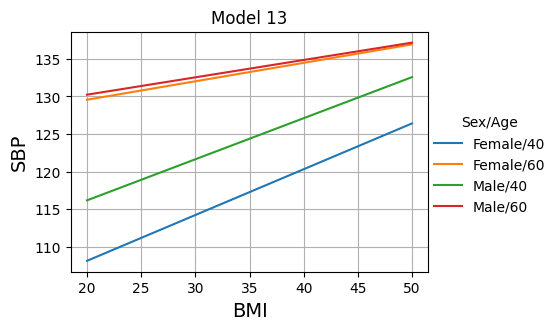

In [ ]:
f13 = "BPXSY1 ~ bs(RIDAGEYR, 5) * BMXBMI * RIAGENDR + (RIAGENDR + bs(RIDAGEYR, 5)) * RIDRETH1"
m13 = sm.OLS.from_formula(f13, df)
r13 = m13.fit()
plot_all(r13, 13)

Model 14 has full interactions among nonlinear age, BMI, sex, and ethnicity.

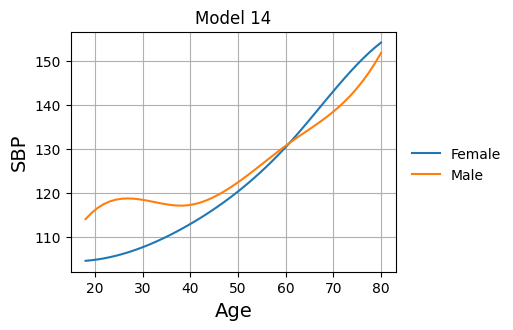

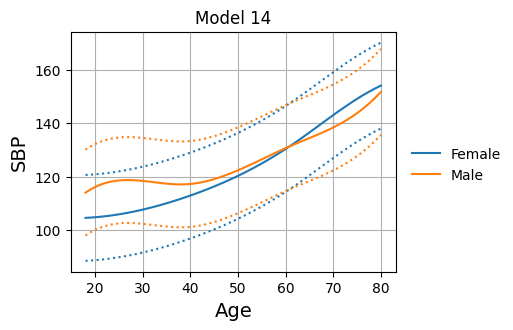

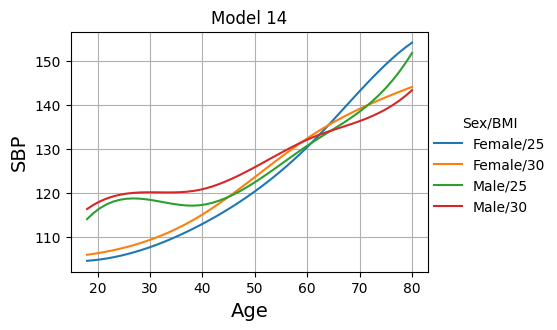

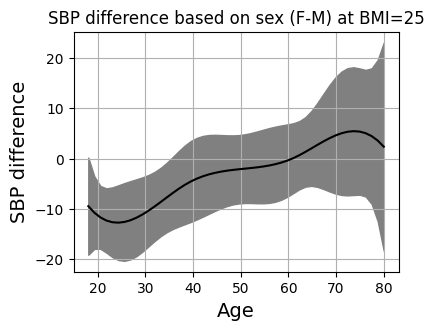

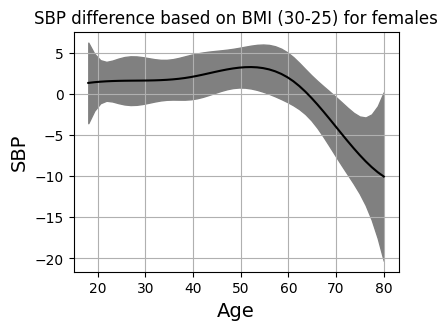

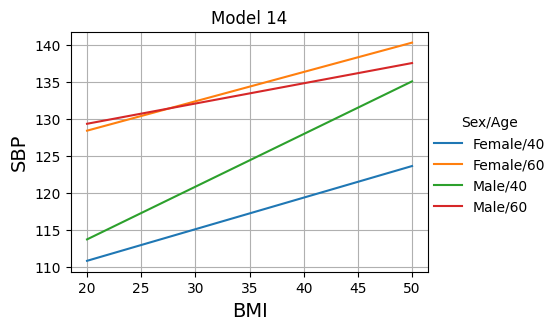

In [ ]:
f14 = "BPXSY1 ~ bs(RIDAGEYR, 5) * BMXBMI * RIAGENDR * RIDRETH1"
m14 = sm.OLS.from_formula(f14, df)
r14 = m14.fit()
plot_all(r14, 14)

Check AICs

In [ ]:
print("AIC for models 0-14:")
maic = [x.aic for x in (r0, r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, r11, r12, r13, r14)]
maic = np.asarray(maic)
maic -= maic.min()
print(maic)

AIC for models 0-14:
[340.12514426 210.53606463 341.55201205 212.39985997 173.04534829
 313.48066346 184.23634209 315.1251606  185.85202143 116.37632869
  15.72732998  17.8302876    0.          14.35554493  47.37483027]


Text(0, 0.5, 'Residuals')

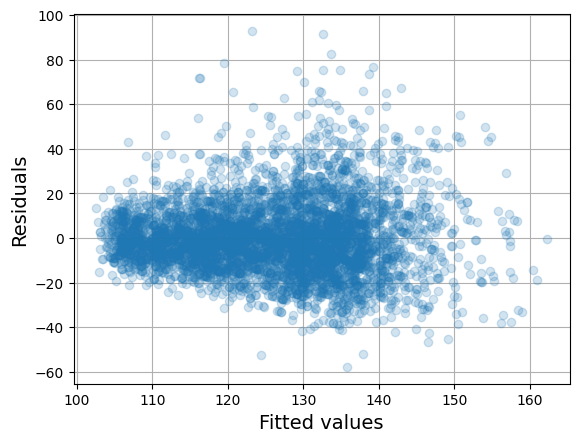

In [ ]:
plt.grid(True)
plt.plot(r12.fittedvalues, r12.resid, "o", alpha=0.2)
plt.xlabel("Fitted values", size=14)
plt.ylabel("Residuals", size=14)

All models above were fit using ordinary least squares (OLS), which works best under homoscedasticity (no relationship between the conditional variance and conditional mean).  We can assess this using the plot below, which reveals an increasing mean/variance relationship.  Since the mean/variance relationship is not strong, especially up to 140 mm Hg where most of the data lie, we have decided to ignore this above.

Text(0, 0.5, 'Residuals')

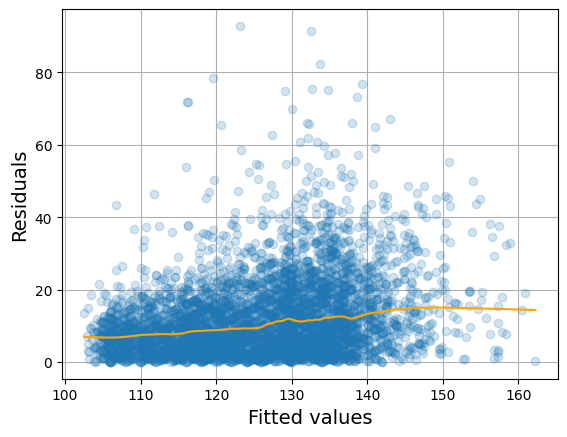

In [ ]:
xl = lowess(np.abs(r12.resid), r12.fittedvalues, frac=0.1)

plt.grid(True)
plt.plot(r12.fittedvalues, np.abs(r12.resid), "o", alpha=0.2)
plt.plot(xl[:, 0], xl[:, 1], "-", color="orange")
plt.xlabel("Fitted values", size=14)
plt.ylabel("Residuals", size=14)

Many of the models above employed B-spline basis functions to capture the nonlinear relationships between quantitative predictors and expected blood pressure.  Below we plot the basis functions for different degrees of freedom.  This is a didactic plot intended to help us understand how the models work.

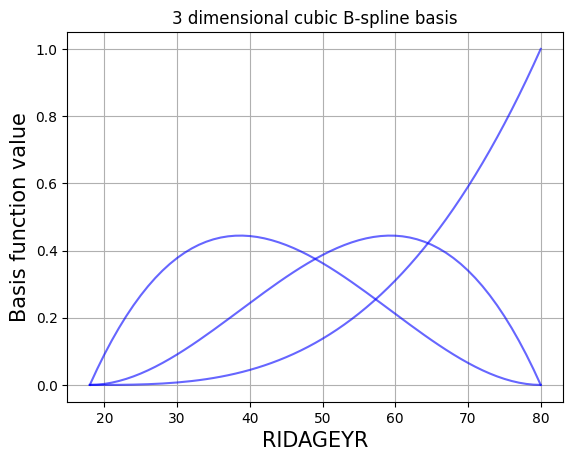

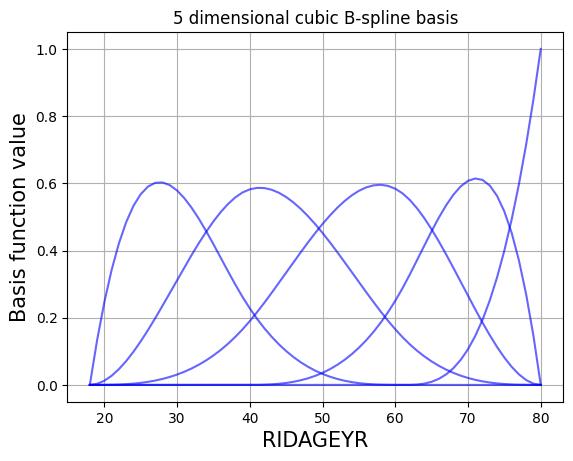

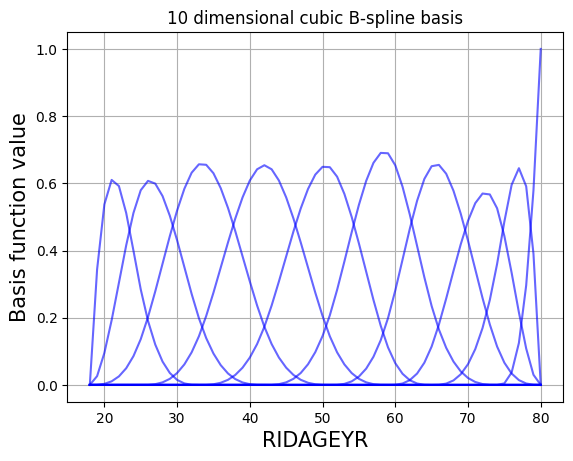

In [ ]:
df = df.sort_values(by="RIDAGEYR")
for j in [3, 5, 10]:
    y = patsy.dmatrix("0 + bs(RIDAGEYR, %d)" % j, df)
    plt.clf()
    plt.grid(True)
    plt.title("%d dimensional cubic B-spline basis" % j)
    for k in range(j):
        plt.plot(df["RIDAGEYR"], y[:, k], "-", color="blue", alpha=0.6)
    plt.xlabel("RIDAGEYR", size=15)
    plt.ylabel("Basis function value", size=15)
    plt.show()